This notebook brings together several iterations of data exploration and using DecisionTreeRegressor from sklearn to make house price predictions.

In [1]:
# load the necessary libraries and functions
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import visuals as vs
%matplotlib inline

C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module 

I'm going to put all the functions I have created for this analysis upfront.

In [2]:
def missing_data_info(df):
    '''
    Takes: a pandas dataframe which is checked for missing data in the columns. Uses any() method to check for 
           missing data.
           
    Returns: prints out the name of columns with missing data, the number of missing values, and the dtype of the column
             and returns a dictionary of the printed data in the form column_name: [#_missing_values, col_dtype]'''
    nan_columns = df.columns[pd.isnull(df).any()].tolist()
    nan_dict = {}
    for i in nan_columns:
        print '{0}: {1} {2}'.format(i, df[i].isnull().sum(), df[i].dtypes)
        nan_dict[i] = [df[i].isnull().sum(), df[i].dtypes]
    return nan_dict

In [3]:
def graph_mean_on_scatter(df, x_name, y_name):
    '''
    Input:
            df: the pandas data frame the data is contained in
            x_name: the name of the df column to plot on the x-axis
            y_name: the name of the df column to plot on the y-axis
    Dependencies: 
            import seaborn as sns
            import numpy as np
            import matplotlib.pyplot as plt
    Returns: 
            A regplot which has any missing values plotted separately in order to evaluate the usefullness of 
            substituting in the mean for the missing data.'''
    missing = pd.DataFrame(data=df[x_name][df[x_name].isnull()], columns=[x_name])
    missing[y_name] = df[y_name][df[x_name].isnull()]
    missing[x_name].fillna(value=np.nanmean(df[x_name]), inplace=True)
    
    sns.regplot(x=x_name, y=y_name, data=df)
    plt.plot(missing[x_name], missing[y_name], 's', markersize=4)
    return plt.show()
    #return

In [4]:
def fill_with_mean(dataframe, column_name):
    '''
    Input: dataframe and the name of a column.
    Output: the dataframe with the column NaN values filled with the column mean
    Dependencies: 
            import numpy as np
            import pandas as pd'''
    mean_column = np.nanmean(dataframe[column_name])
    dataframe[column_name].fillna(value=mean_column, inplace=True)
    return dataframe

In [5]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. 
        DEPENDENCIES: from sklearn.metrics import r2_score"""
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [6]:
def make_submission(test_data, test_data_index, predictor, k):
    '''
    test_data = a pandas dataframe containing the test data
    predictor = a trained classifier
    k = the number of the entry. Used to keep older entries from being overwritten
    output: writes a csv file to the current directory'''
    predictions = predictor.predict(test_data)
    test_id = test_data_index
    submission = pd.DataFrame(data=predictions, index=test_id, columns=['SalePrice'])
    print submission.head()
    submission.to_csv('DTR_submission{}.csv'.format(k))

In [7]:
train = pd.read_csv('houseTrain.csv')
test = pd.read_csv('houseTest.csv')
print np.shape(train)
print np.shape(test)

(1460, 81)
(1459, 80)


In [8]:
missing_data_info(train)

LotFrontage: 259 float64
Alley: 1369 object
MasVnrType: 8 object
MasVnrArea: 8 float64
BsmtQual: 37 object
BsmtCond: 37 object
BsmtExposure: 38 object
BsmtFinType1: 37 object
BsmtFinType2: 38 object
Electrical: 1 object
FireplaceQu: 690 object
GarageType: 81 object
GarageYrBlt: 81 float64
GarageFinish: 81 object
GarageQual: 81 object
GarageCond: 81 object
PoolQC: 1453 object
Fence: 1179 object
MiscFeature: 1406 object


{'Alley': [1369, dtype('O')],
 'BsmtCond': [37, dtype('O')],
 'BsmtExposure': [38, dtype('O')],
 'BsmtFinType1': [37, dtype('O')],
 'BsmtFinType2': [38, dtype('O')],
 'BsmtQual': [37, dtype('O')],
 'Electrical': [1, dtype('O')],
 'Fence': [1179, dtype('O')],
 'FireplaceQu': [690, dtype('O')],
 'GarageCond': [81, dtype('O')],
 'GarageFinish': [81, dtype('O')],
 'GarageQual': [81, dtype('O')],
 'GarageType': [81, dtype('O')],
 'GarageYrBlt': [81, dtype('float64')],
 'LotFrontage': [259, dtype('float64')],
 'MasVnrArea': [8, dtype('float64')],
 'MasVnrType': [8, dtype('O')],
 'MiscFeature': [1406, dtype('O')],
 'PoolQC': [1453, dtype('O')]}

Now we have a list of the columns that contain missing data. Reading the provided metadata tells us that many of these columns use Na values to indicate that the house does not have the feature. So the data is not actually "missing". The columns that use this convention are Alley, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, Fence, GarageCond, GarageFinish, FireplaceQu, GarageQual, GarageType, MiscFeature, PoolQC.

Let's change the Na values to "Nope" to avoid any confusion with None type.

In [9]:
for i in ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'FireplaceQu', 
          'Fence', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'MiscFeature', 'PoolQC']:
    train.loc[:,i].fillna(value='Nope', inplace=True)

In [10]:
missing_data_info(train)

LotFrontage: 259 float64
MasVnrType: 8 object
MasVnrArea: 8 float64
Electrical: 1 object
GarageYrBlt: 81 float64


{'Electrical': [1, dtype('O')],
 'GarageYrBlt': [81, dtype('float64')],
 'LotFrontage': [259, dtype('float64')],
 'MasVnrArea': [8, dtype('float64')],
 'MasVnrType': [8, dtype('O')]}

There isn't an Na type for the remaining categorical features Electrical and MasVnrType. Let's take a look at these variables using boxplots.

The price of the house with missing electricity feature is:


1379    167500
Name: SalePrice, dtype: int64

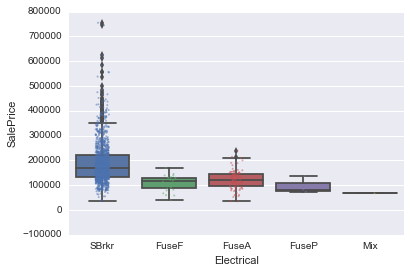

In [11]:
sns.boxplot(x='Electrical', y='SalePrice', data=train)
sns.stripplot(x='Electrical', y='SalePrice', data=train, size = 2, jitter=True, alpha=0.5)
print 'The price of the house with missing electricity feature is:'
train.SalePrice[train.Electrical.isnull()]

In [12]:
# Since so many of the values are SBrkr and the price of the house missing the data is pretty close to the median of
# the SBrkr values, I'm going to assign the missing value to SBrkr
train.Electrical.fillna(value="SBrkr", inplace=True)

The mean price of the houses with missing veneer feature is:


236484.25

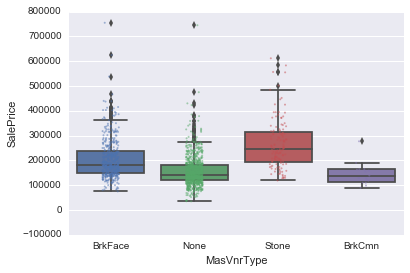

In [13]:
sns.boxplot(x='MasVnrType', y='SalePrice', data=train)
sns.stripplot(x='MasVnrType', y='SalePrice', data=train, size = 2, jitter=True, alpha=0.5)
print 'The mean price of the houses with missing veneer feature is:'
np.mean(train.SalePrice[train.MasVnrType.isnull()])

The mean price of these houses with the missing data looks like it could be in either the BrkFace or the Stone categories. I'm going to label the missing data as BrkFace because 1) it is much more common than the Stone and 2) the mean value of the missing data looks like it less than the 3rd quartile value of the BrkFace, so it isn't to different.

In [14]:
train.MasVnrType.fillna(value="BrkFace", inplace=True)

In [15]:
# That leaves just the continuous variables to fill
missing_data_info(train)

LotFrontage: 259 float64
MasVnrArea: 8 float64
GarageYrBlt: 81 float64


{'GarageYrBlt': [81, dtype('float64')],
 'LotFrontage': [259, dtype('float64')],
 'MasVnrArea': [8, dtype('float64')]}

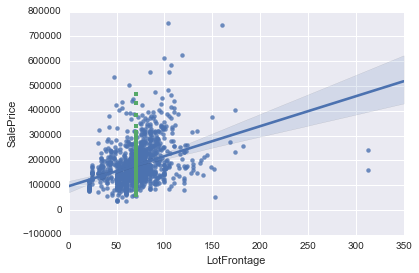

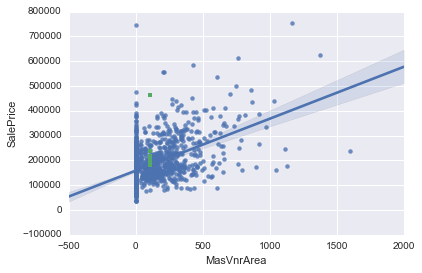

In [16]:
graph_mean_on_scatter(train, 'LotFrontage', 'SalePrice')
graph_mean_on_scatter(train, 'MasVnrArea', 'SalePrice')

Filling the missing LotFrontage values seems to be a decent strategy. Another potential strategy would be to impute the values using the correlation between LotFrontage and LotArea or LotFrontage and 1stFlrSF. The notebook below has a really good correlation plot for all the features:
https://www.kaggle.com/xchmiao/house-prices-advanced-regression-techniques/detailed-data-exploration-in-python

In [17]:
fill_with_mean(train, 'LotFrontage')
fill_with_mean(train, 'MasVnrArea')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,Nope,Reg,Lvl,AllPub,...,0,Nope,Nope,Nope,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,Nope,Reg,Lvl,AllPub,...,0,Nope,Nope,Nope,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,Nope,IR1,Lvl,AllPub,...,0,Nope,Nope,Nope,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,Nope,IR1,Lvl,AllPub,...,0,Nope,Nope,Nope,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,Nope,IR1,Lvl,AllPub,...,0,Nope,Nope,Nope,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000000,14115,Pave,Nope,IR1,Lvl,AllPub,...,0,Nope,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000000,10084,Pave,Nope,Reg,Lvl,AllPub,...,0,Nope,Nope,Nope,0,8,2007,WD,Normal,307000
7,8,60,RL,70.049958,10382,Pave,Nope,IR1,Lvl,AllPub,...,0,Nope,Nope,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000000,6120,Pave,Nope,Reg,Lvl,AllPub,...,0,Nope,Nope,Nope,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000000,7420,Pave,Nope,Reg,Lvl,AllPub,...,0,Nope,Nope,Nope,0,1,2008,WD,Normal,118000


That leaves just one feature unfilled: GarageYrBlt. This is a tricky one to do anything with. The GarageYrBlt correlates strongly with YearBuilt, but it doesn't make sense to impute those values because there is no garage! I'm going to simply drop this one from the features list (and therefore, the test set as well).

In [18]:
train.drop('GarageYrBlt', axis=1, inplace=True)
test.drop('GarageYrBlt', axis=1, inplace=True)

Now that all the missing data has been handled, I'm going to split the features into numerical and categorical features. Then we need to decide if a particular categorical feature is ordinal or not. If it is, we can use the LabelEncoder to convert the ordered values to numbers. If it's not, we will use OneHotEncoder to create dummy variables out of the encoded numbers.

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = train.select_dtypes(include=numerics)
categorical_features = train.select_dtypes(exclude=numerics)

In [20]:
#for i in numeric_features.columns.values:
#    sns.regplot(x=i, y='SalePrice', data=train)
#    plt.show()
#    plt.close()

Based on these graphs and the metadata:
    MSSubClass should be OneHotEncoded
    YrSold, MoSold, MiscValue, LowQualFinSF, and BsmtHalfBath should be dropped from the model.

I'm curious that homes with greater size of the BsmtFinSF2 have lower prices so let's create some plots to look at this in a little more detail. First, let's look at the BsmtFinType2 in relation to the BsmtFinSF2 and the look at how the BsmtFinType2 compared to the SalePrice. These charts can show us if there is an interaction between the categorical variable and the numerical variable. Are the nicer basements smaller? Does the basement type have any relation to the price?

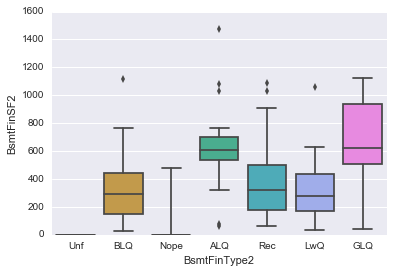

In [21]:
sns.boxplot(x='BsmtFinType2', y='BsmtFinSF2', data=train)
# GLQ = Good Living Quarters
# ALQ = Average Living Quarters
# BLQ = Below Average Living Quarters	
# Rec = Average Rec Room
# LwQ = Low Quality
# Unf = Unfinshed
# NA = No Basement
# NA doesn't show up because the training data was not altered.

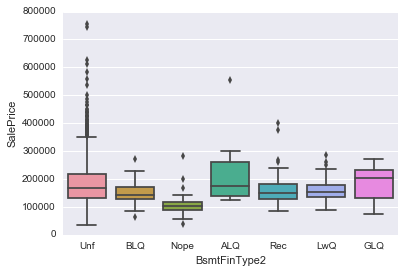

In [22]:
sns.boxplot(x='BsmtFinType2', y='SalePrice', data=train)

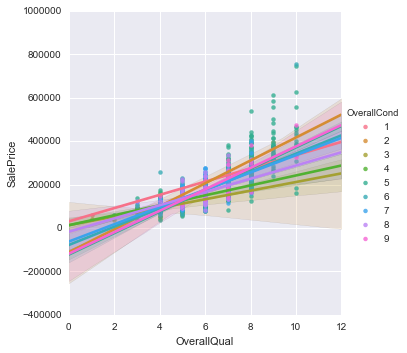

In [23]:
# bonus plot showing some cool features of seaborn!
sns.lmplot('OverallQual', 'SalePrice', data=train, hue='OverallCond')

In [24]:
# drop the named features
train.drop(['YrSold', 'MoSold', 'MiscVal', 'LowQualFinSF', 'BsmtHalfBath'], axis=1, inplace=True)

In [25]:
# encode MSSubClass
le1 = LabelEncoder()
train['MSSubClass_le'] = le1.fit_transform(train.MSSubClass)

In [26]:
# one hot encode MSSubClass_le
new_dummies = pd.get_dummies(train['MSSubClass_le'], sparse=False).rename(
            columns=lambda x: 'MSSubClass'+str(x))
train = pd.concat([train, new_dummies], axis=1)

# and drop MSSubClass
train.drop(['MSSubClass', 'MSSubClass_le'], axis=1, inplace=True)
train.head()

,Id,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MSSubClass5,MSSubClass6,MSSubClass7,MSSubClass8,MSSubClass9,MSSubClass10,MSSubClass11,MSSubClass12,MSSubClass13,MSSubClass14
0,1,RL,65.0,8450,Pave,Nope,Reg,Lvl,AllPub,Inside,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,RL,80.0,9600,Pave,Nope,Reg,Lvl,AllPub,FR2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,RL,68.0,11250,Pave,Nope,IR1,Lvl,AllPub,Inside,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,RL,60.0,9550,Pave,Nope,IR1,Lvl,AllPub,Corner,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,RL,84.0,14260,Pave,Nope,IR1,Lvl,AllPub,FR2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Now lets do the above to the categorical features
#for i in categorical_features.columns.values:
#    sns.boxplot(x=i, y='SalePrice', data=train)
#    sns.stripplot(x=i, y='SalePrice', hue='MasVnrType', data=train, jitter=True, alpha=0.6)
#    plt.show()
#    plt.close()

Labels to be LabelEncoded (they have an order): LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, CentralAir, KitchenQual, Functional, FireplaceQu, GarageFin, GarageQual, GarageCond, PavedDrive, PoolQu

Labels to be coded with dummy variables (they don't have an order): MSZoning, Street, Alley, LotShape, LandContour, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMat1, Exterior1sr, Exterior2nd, MasVnrType, Foundation, Electrical, GarageType, Fence, SaleType, SaleCondition 

Labels to drop: Utilities, Heating, MiscFeatures

Factoring by MasVnrType gives an interesting look at the data. The Stone veneers are clearly in all of the higher priced categorical variables and is definitely a marker of a more desired (i.e., higher priced building). I chose it just as a quick way to test how this type of chart would look and I think it turned out great!

In [28]:
# ordered label encoding
land_slope = {'title':'LandSlopeLE', 'target':'LandSlope', 'mapping':{'Gtl':0 ,'Mod': 1,'Sev':2}}
exter_qual = {'title':'ExterQualLE', 'target':'ExterQual', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
exter_cond = {'title':'ExterCondLE', 'target':'ExterCond', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
bsmt_qual = {'title':'BsmtQualLE', 'target':'BsmtQual', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
bsmt_cond = {'title':'BsmtCondLE', 'target':'BsmtCond', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
bsmt_exposure = {'title':'BsmtExposureLE', 'target':'BsmtExposure', 'mapping':{'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'Nope':0}}
bsmt_fin_type1 = {'title':'BsmtFinType1LE', 'target':'BsmtFinType1', 'mapping':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'Nope':0}}
bsmt_fin_type2 = {'title':'BsmtFinType2LE', 'target':'BsmtFinType2', 'mapping':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'Nope':0}}
heating_qc = {'title':'HeatingQCLE', 'target':'HeatingQC', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
central_air = {'title':'CentralAirLE', 'target':'CentralAir', 'mapping':{'N':0, 'Y':1}}
kitchen_qual = {'title':'KitchenQualLE', 'target':'KitchenQual', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
functional = {'title':'FunctionalLE', 'target':'Functional', 'mapping':{'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}}
fireplace_qu = {'title':'FireplaceQuLE', 'target':'FireplaceQu', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
garage_finish = {'title':'GarageFinishLE', 'target':'GarageFinish', 'mapping':{'Fin':3, 'RFn':2, 'Unf':1, 'Nope':0}}
garage_qual = {'title':'GarageQualLE', 'target':'GarageQual', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
garage_cond = {'title':'GarageCondLE', 'target':'GarageCond', 'mapping':{'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Nope':0}}
paved_drive = {'title':'PavedDriveLE', 'target':'PavedDrive', 'mapping':{'Y':2, 'P':1, 'N':0}}
pool_qc = {'title':'PoolQCLE', 'target':'PoolQC', 'mapping':{'Ex': 4, 'Gd':3, 'TA':2, 'Fa':1, 'Nope':0}}

In [29]:
maps = [land_slope, exter_qual, exter_cond, bsmt_qual, bsmt_cond, bsmt_exposure, bsmt_fin_type1, bsmt_fin_type2,
       heating_qc, central_air, kitchen_qual, functional, fireplace_qu, garage_finish, garage_qual, garage_cond,
       paved_drive, pool_qc]
for mapp in maps:
    title = mapp['title']
    train_target =  mapp['target']
    train[title] = train[train_target].map(mapp['mapping'])
    train.drop([train_target], axis=1, inplace=True)

In [30]:
# one hot encoding
ohe_lables = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 
              'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
              'MasVnrType', 'Foundation', 'Electrical', 'GarageType', 'Fence', 'SaleType', 'SaleCondition']
# one hot encode the ohe_labels:
for i in ohe_lables:
    train[i+'_le'] = le1.fit_transform(train[i])
    new_dummies = pd.get_dummies(train[i+'_le'], sparse=False).rename(
            columns=lambda x: i+str(x))
    train = pd.concat([train, new_dummies], axis=1)
    # and drop the original label
    train.drop([i, i+'_le'], axis=1, inplace=True)

In [31]:
cats_to_drop = ['Utilities', 'Heating', 'MiscFeature', 'Condition25', 'Condition26', 'Condition27', 'HouseStyle7',
                'RoofMatl4', 'RoofMatl5', 'RoofMatl6', 'RoofMatl7', 'Exterior1st14', 'Electrical4']
train.drop(cats_to_drop, axis=1, inplace=True)

In [32]:
# Before training the model we need to remove the target from the input features
target = train.SalePrice
features = train.drop(['SalePrice', 'Id'], axis=1)

# now need to replace missing values and encode the categorical variables in the test data

In [33]:
#missing_data_info(test)

In [34]:
for i in ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'FireplaceQu', 'Exterior1st',
          'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 
          'GarageType', 'KitchenQual', 'MSZoning', 'MiscFeature', 'PoolQC', 'SaleType', 'Utilities']:
    test.loc[:,i].fillna(value='Nope', inplace=True)

In [35]:
# replace the missing MasVnrType with BrkFace
test.MasVnrType.fillna(value="BrkFace", inplace=True)

In [36]:
for i in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 
         'LotFrontage', 'MasVnrArea', 'TotalBsmtSF']:
    fill_with_mean(test, i)

In [37]:
# do the encoding of the necessary features as was done in the training set
for mapp in maps:
    title = mapp['title']
    test_target =  mapp['target']
    test[title] = test[test_target].map(mapp['mapping'])
    test.drop([test_target], axis=1, inplace=True)



In [38]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,HeatingQCLE,CentralAirLE,KitchenQualLE,FunctionalLE,FireplaceQuLE,GarageFinishLE,GarageQualLE,GarageCondLE,PavedDriveLE,PoolQCLE
0,1461,20,RH,80.0,11622,Pave,Nope,Reg,Lvl,AllPub,...,3,1,3,7.0,0,1,3,3,2,0
1,1462,20,RL,81.0,14267,Pave,Nope,IR1,Lvl,AllPub,...,3,1,4,7.0,0,1,3,3,2,0
2,1463,60,RL,74.0,13830,Pave,Nope,IR1,Lvl,AllPub,...,4,1,3,7.0,3,3,3,3,2,0
3,1464,60,RL,78.0,9978,Pave,Nope,IR1,Lvl,AllPub,...,5,1,4,7.0,4,3,3,3,2,0
4,1465,120,RL,43.0,5005,Pave,Nope,IR1,HLS,AllPub,...,5,1,4,7.0,0,2,3,3,2,0


In [39]:
# one hot encoding
ohe_lables = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 
              'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
              'MasVnrType', 'Foundation', 'Electrical', 'GarageType', 'Fence', 'SaleType', 'SaleCondition']
# one hot encode the ohe_labels:
for i in ohe_lables:
    test[i+'_le'] = le1.fit_transform(test[i])
    new_dummies = pd.get_dummies(test[i+'_le'], sparse=False).rename(
            columns=lambda x: i+str(x))
    test = pd.concat([test, new_dummies], axis=1)
    # and drop the original label
    test.drop([i, i+'_le'], axis=1, inplace=True)

In [40]:
test.head()

,Id,LotFrontage,LotArea,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType6,SaleType7,SaleType8,SaleType9,SaleCondition0,SaleCondition1,SaleCondition2,SaleCondition3,SaleCondition4,SaleCondition5
0,1461,80.0,11622,AllPub,5,6,1961,1961,0.0,468.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1462,81.0,14267,AllPub,6,6,1958,1958,108.0,923.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1463,74.0,13830,AllPub,5,5,1997,1998,0.0,791.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1464,78.0,9978,AllPub,6,6,1998,1998,20.0,602.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1465,43.0,5005,AllPub,8,5,1992,1992,0.0,263.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
IDs = test.Id
drop_test = ['Utilities', 'Heating', 'MiscFeature', 'Id', 'YrSold', 'MoSold', 'MiscVal', 
             'LowQualFinSF', 'BsmtHalfBath']
test = test.drop(drop_test, axis=1)

In [42]:
test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType6,SaleType7,SaleType8,SaleType9,SaleCondition0,SaleCondition1,SaleCondition2,SaleCondition3,SaleCondition4,SaleCondition5
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
for i in test.columns.values:
    if i not in list(features.columns.values):
        print i

MSSubClass15
MSZoning5
SaleType9


In [44]:
for i in features.columns.values:
    if i not in list(test.columns.values):
        print i

In [45]:
test.drop(['MSSubClass15', 'MSZoning5', 'SaleType9'], axis=1, inplace=True)

In [46]:
print np.shape(features)
print np.shape(target)
features.drop(['FunctionalLE'], axis=1, inplace=True)
test.drop(['FunctionalLE'], axis=1, inplace=True)

(1460, 217)
(1460L,)


In [47]:
for i in test.columns.values:
    print i, test[i].isnull().any()

LotFrontage False
LotArea False
OverallQual False
OverallCond False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
GrLivArea False
BsmtFullBath False
FullBath False
HalfBath False
BedroomAbvGr False
KitchenAbvGr False
TotRmsAbvGrd False
Fireplaces False
GarageCars False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
LandSlopeLE False
ExterQualLE False
ExterCondLE False
BsmtQualLE False
BsmtCondLE False
BsmtExposureLE False
BsmtFinType1LE False
BsmtFinType2LE False
HeatingQCLE False
CentralAirLE False
KitchenQualLE False
FireplaceQuLE False
GarageFinishLE False
GarageQualLE False
GarageCondLE False
PavedDriveLE False
PoolQCLE False
MSSubClass0 False
MSSubClass1 False
MSSubClass2 False
MSSubClass3 False
MSSubClass4 False
MSSubClass5 False
MSSubClass6 False
MSSubClass7 False
MSSubClass8 False
MSSubClass9 False
MSSu

In [56]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_features = min_max_scaler.fit_transform(features)
scaled_test = min_max_scaler.transform(test)
from sklearn.decomposition import PCA
pca = PCA(n_components=85).fit(scaled_features)
pca_features = pca.transform(scaled_features)
pca_test = pca.transform(scaled_test)
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(pca_features, target, test_size = 0.2)
rf = RandomForestRegressor(max_depth= 20,min_samples_split=5, min_samples_leaf=5)
rf.fit(X_train, y_train)
print rf.score(X_test, y_test)
make_submission(pca_test, IDs, rf, 25)
# FYI this cell got a really bad score

0.644892552181
          SalePrice
Id                 
1461   95975.566570
1462  154609.729876
1463  151392.221996
1464  204440.044739
1465  121652.757937


In [53]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.98723581,  0.99219414,  0.99558868,  0.9983626 ,  0.99886481,
        0.99918885,  0.99948755,  0.99971454,  0.99985362,  0.99989478,
        0.9999284 ,  0.99995704,  0.99997217,  0.9999806 ,  0.99998847])

In [48]:
parameters = {'max_depth':[1,3,6,10,20], 'min_samples_split':[2,5,10,15,18,20,23,25,28,30,40,50,100], 
              'min_samples_leaf':[1,5,10,12,15,17,20,40]}
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
reg = DecisionTreeRegressor()
clf = GridSearchCV(reg, parameters)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_test, y_test)

0.769067591617
{'min_samples_split': 20, 'max_depth': 20, 'min_samples_leaf': 1}
0.683522923586


In [49]:
print np.shape(features)
print np.shape(test)
make_submission(test, IDs, clf, 7)

(1460, 216)
(1459, 216)
          SalePrice
Id                 
1461   62714.285714
1462  161200.000000
1463  199883.333333
1464  196796.875000
1465  219111.111111


In [134]:
from sklearn.linear_model import Ridge
r2_scorer = make_scorer(performance_metric)
ridge_parameters = {'alpha':np.logspace(-7, 3, 3), 'normalize':[True,False]}
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
ridge = Ridge(fit_intercept=True)
rid_clf = GridSearchCV(ridge, ridge_parameters)
rid_clf.fit(X_train, y_train)
print rid_clf.best_score_
print rid_clf.best_params_
print rid_clf.score(X_test, y_test)

0.846330100274
{'normalize': True, 'alpha': 0.01}
0.552477901551


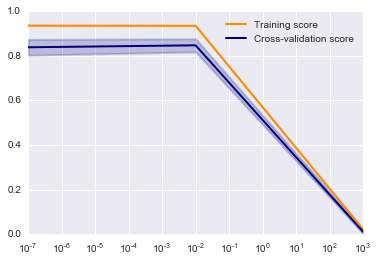

In [138]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(-7, 3, 3)
train_scores, test_scores = validation_curve(Ridge(normalize=True), X_train, y_train, "alpha",
                                              param_range)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [75]:
make_submission(test, IDs, rid_clf, 8)
# not a valid submission

         SalePrice
Id                
1461  36734.410853
1462  68785.639087
1463  42498.091228
1464  38281.728197
1465  75575.899386


In [88]:
from sklearn.linear_model import RidgeCV
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
ridgecv = RidgeCV(alphas=(15.0,20.0,25.0,30.0,50.0), normalize=False, scoring=r2_scorer, cv=5)
ridgecv.fit(X_train, y_train)
print ridgecv.score(X_test, y_test)
make_submission(test, IDs, ridgecv, 9)

0.69842205769
          SalePrice
Id                 
1461   96388.797906
1462  135797.480433
1463  125492.677011
1464  130362.556117
1465  159015.662952


In [89]:
from sklearn.linear_model import LassoCV
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
lassocv = LassoCV(alphas=(15.0,20.0,25.0,30.0,50.0), normalize=True, cv=10)
lassocv.fit(X_train, y_train)
print lassocv.score(X_test, y_test)
make_submission(test, IDs, lassocv, 10)

0.606951543543
          SalePrice
Id                 
1461   74229.477917
1462  117799.696248
1463  113132.284223
1464  117820.823939
1465  138488.118501


In [116]:
from sklearn.linear_model import ElasticNetCV
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=1000, 
                  alphas=(1.0, 5.0,10.0,15.0,20.0,25.0,30.0,50.0), fit_intercept=True, normalize=True, 
                  precompute='auto', max_iter=1000, tol=0.0001, cv=10)
en.fit(X_train, y_train)
print en.score(X_test, y_test)
make_submission(test, IDs, en, 11)

0.606951543543
          SalePrice
Id                 
1461   74229.477917
1462  117799.696248
1463  113132.284223
1464  117820.823939
1465  138488.118501


In [117]:
from sklearn.neural_network import MLPRegressor
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)

nnet = MLPRegressor()
nnet.fit(X_train, y_train)
print nnet.score(X_test, y_test)
#nn_params = {'hidden_layer_sizes':[(100,2),(100,4),(150,2)], 'solver':['lbfgs','adam','sgd'],'alpha':[0.0001,0.01,
#                                                                                                    0.1,1,10,20,30],
#            'max_iter':[1000]}
#nn_clf = GridSearchCV(nnet, nn_params)
#nn_clf.fit(X_train, y_train)
#print nn_clf.score(X_test, y_test)

0.520629464947


## Use the LassoCV results to get only the columns with non-zero coefficients and train models using these columns using DTR, Ridge, Lasso, ElasticNet, and Neural Net

In [163]:
zero_coefs = lassocv.coef_ != 0
lasso_df_train = features.loc[:,zero_coefs]
lasso_df_test = test.loc[:,list(lasso_df_train.columns.values)]
print np.shape(lasso_df_train)
print np.shape(lasso_df_test)
for i in range(len(lasso_df_train)):
    print lasso_df_train.columns.values[i],'\t', lasso_df_test.columns.values[i]

(1460, 86)
(1459, 86)
LotFrontage 	LotFrontage
LotArea 	LotArea
OverallQual 	OverallQual
OverallCond 	OverallCond
YearBuilt 	YearBuilt
MasVnrArea 	MasVnrArea
BsmtFinSF1 	BsmtFinSF1
BsmtFinSF2 	BsmtFinSF2
TotalBsmtSF 	TotalBsmtSF
GrLivArea 	GrLivArea
BsmtFullBath 	BsmtFullBath
FullBath 	FullBath
HalfBath 	HalfBath
BedroomAbvGr 	BedroomAbvGr
KitchenAbvGr 	KitchenAbvGr
TotRmsAbvGrd 	TotRmsAbvGrd
Fireplaces 	Fireplaces
GarageCars 	GarageCars
GarageArea 	GarageArea
WoodDeckSF 	WoodDeckSF
OpenPorchSF 	OpenPorchSF
ScreenPorch 	ScreenPorch
MSSubClass5 	MSSubClass5
MSSubClass9 	MSSubClass9
MSSubClass12 	MSSubClass12
ExterQualLE 	ExterQualLE
BsmtQualLE 	BsmtQualLE
BsmtCondLE 	BsmtCondLE
BsmtExposureLE 	BsmtExposureLE
BsmtFinType1LE 	BsmtFinType1LE
HeatingQCLE 	HeatingQCLE
KitchenQualLE 	KitchenQualLE
MSZoning0 	MSZoning0
MSZoning1 	MSZoning1
MSZoning4 	MSZoning4
Street0 	Street0
LotShape1 	LotShape1
LandContour1 	LandContour1
LandContour2 	LandContour2
LotConfig1 	LotConfig1
Neighborhood3 	Neigh

IndexError: index 86 is out of bounds for axis 0 with size 86

# Decision Tree Regressor with LassoCV Selected Features

In [164]:
parameters = {'max_depth':[1,3,6,10,20], 'min_samples_split':[2,5,10,15,18,20,23,25,28,30,40,50,100], 
              'min_samples_leaf':[1,5,10,12,15,17,20,40]}
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2, random_state=0)
reg = DecisionTreeRegressor()
clf = GridSearchCV(reg, parameters)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_test, y_test)
make_submission(lasso_df_test, IDs, clf, 12)

0.767876885844
{'min_samples_split': 30, 'max_depth': 10, 'min_samples_leaf': 10}
0.757995070732
          SalePrice
Id                 
1461  119761.538462
1462  157518.965517
1463  189416.000000
1464  196796.875000
1465  202730.769231


## Ridge Regression with LassoCV Selected Features

In [165]:
ridge_parameters = {'alpha':np.logspace(-7, 3, 3), 'normalize':[True,False]}
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2, random_state=0)
ridge = Ridge(fit_intercept=True)
rid_clf = GridSearchCV(ridge, ridge_parameters)
rid_clf.fit(X_train, y_train)
print rid_clf.best_score_
print rid_clf.best_params_
print rid_clf.score(X_test, y_test)
make_submission(lasso_df_test, IDs, rid_clf, 13)

0.872312365336
{'normalize': True, 'alpha': 0.01}
0.584549475803
          SalePrice
Id                 
1461  143966.503693
1462  189959.913843
1463  187824.011676
1464  198462.487232
1465  227389.574572


In [166]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2, random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
print lr.score(X_test, y_test)
make_submission(lasso_df_test, IDs, lr, 14)

0.577923749521
          SalePrice
Id                 
1461  143274.148939
1462  189485.489178
1463  186882.851472
1464  196967.357846
1465  226309.385994


In [167]:
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2, random_state=0)
lassocv = LassoCV(alphas=(15.0,20.0,25.0,30.0,50.0), normalize=True, cv=10)
lassocv.fit(X_train, y_train)
print lassocv.score(X_test, y_test)
make_submission(lasso_df_test, IDs, lassocv, 15)

0.600821195658
          SalePrice
Id                 
1461  132646.314832
1462  183530.347888
1463  180750.711900
1464  192622.653369
1465  218430.921600


In [168]:
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2, random_state=0)
en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=1000, 
                  alphas=(1.0, 5.0,10.0,15.0,20.0,25.0,30.0,50.0), fit_intercept=True, normalize=True, 
                  precompute='auto', max_iter=1000, tol=0.0001, cv=10)
en.fit(X_train, y_train)
print en.score(X_test, y_test)
make_submission(lasso_df_test, IDs, en, 16)

0.585879943033
          SalePrice
Id                 
1461  139675.350601
1462  187380.405826
1463  185143.146463
1464  195878.223220
1465  223485.502267


In [169]:
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2, random_state=0)
nnet = MLPRegressor()
nnet.fit(X_train, y_train)
print nnet.score(X_test, y_test)
make_submission(lasso_df_test, IDs, nnet, 17)

0.478152718427
          SalePrice
Id                 
1461  166899.398946
1462  206164.017070
1463  196197.322207
1464  192830.082410
1465  168397.866278


# The linear regression models (LinearRegression, Ridge, Lasso, Elastic Net) produce some negative value predictions?

Could the error be due to passing the dataframe instead of a matrix to the algorithms?

In [172]:
lasso_mat_train = np.array(lasso_df_train)
lasso_mat_test = np.array(lasso_df_test)

In [197]:
ridge_parameters = {'alpha':np.logspace(-7, 3, 3), 'normalize':[True,False]}
X_train, X_test, y_train, y_test = train_test_split(lasso_mat_train, target, test_size = 0.2)
ridge = Ridge(fit_intercept=True)
rid_clf = GridSearchCV(ridge, ridge_parameters)
rid_clf.fit(X_train, y_train)
print rid_clf.best_score_
print rid_clf.best_params_
print rid_clf.score(X_test, y_test)
make_submission(lasso_mat_test, IDs, rid_clf, 18)

0.780926194029
{'normalize': True, 'alpha': 0.01}
0.906214185413
          SalePrice
Id                 
1461   86034.298799
1462  158589.384271
1463  123184.324667
1464  138366.924369
1465  214818.868050


In [198]:
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2)
en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=1000, 
                  alphas=(1.0, 5.0,10.0,15.0,20.0,25.0,30.0,50.0), fit_intercept=True, normalize=True, 
                  precompute='auto', max_iter=1000, tol=0.0001, cv=10)
en.fit(X_train, y_train)
print en.score(X_test, y_test)
make_submission(lasso_df_test, IDs, en, 19)

0.883750263337
          SalePrice
Id                 
1461   97228.970153
1462  164086.287322
1463  151056.764512
1464  169888.730315
1465  226517.033997


## The LassoCV followed by the Elastic Net gave me my best score of 0.16731!

In [205]:
X_train, X_test, y_train, y_test = train_test_split(lasso_df_train, target, test_size = 0.2)
en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=1000, 
                  alphas=(1.0, 5.0,10.0,15.0,20.0,25.0,30.0,50.0), fit_intercept=True, normalize=True, 
                  precompute='auto', max_iter=1000, tol=0.0001, cv=10)
en.fit(X_train, y_train)
print en.score(X_test, y_test)
make_submission(lasso_df_test, IDs, en, 20)

0.899208487249
          SalePrice
Id                 
1461  101522.955073
1462  161792.419539
1463  151647.843439
1464  173297.891611
1465  222726.581226


In [206]:
from sklearn.ensemble import RandomForestRegressor
parameters = {'max_depth':[1,3,6,10,20], 'min_samples_split':[2,5,10,15,18,20,23,25,28,30,40,50,100], 
              'min_samples_leaf':[1,5,10,12,15,17,20,40]}
X_train, X_test, y_train, y_test = train_test_split(lasso_mat_train, target, test_size = 0.2)
rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_test, y_test)
make_submission(lasso_mat_test, IDs, clf, 21)

0.843187350501
{'min_samples_split': 5, 'max_depth': 20, 'min_samples_leaf': 5}
0.864908200583
          SalePrice
Id                 
1461  131860.029762
1462  159011.340852
1463  165399.913309
1464  171882.914377
1465  217773.910839


In [57]:
parameters = {'max_depth':[1,3,6,10,20], 'min_samples_split':[2,5,10,15,18,20,23,25,28,30,40,50,100], 
              'min_samples_leaf':[1,5,10,12,15,17,20,40]}
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size = 0.2)
rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_test, y_test)
make_submission(scaled_test, IDs, clf, 26)

0.841059314093
{'min_samples_split': 5, 'max_depth': 20, 'min_samples_leaf': 1}
0.838316552596
          SalePrice
Id                 
1461   99958.611111
1462  122898.472222
1463  165747.452381
1464  170206.738095
1465  203365.000000


## Using the RandomForest is my new best entry: 0.16074

In [209]:
parameters = {'max_depth':[1,3,6,10,20], 'min_samples_split':[2,5,10,15,18,20,23,25,28,30,40,50,100], 
              'min_samples_leaf':[1,5,10,12,15,17,20,40], 'n_estimators':[5,10,15,20]}
X_train, X_test, y_train, y_test = train_test_split(lasso_mat_train, target, test_size = 0.2)
rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_test, y_test)
make_submission(lasso_mat_test, IDs, clf, 22)

0.854571225255
{'min_samples_split': 2, 'n_estimators': 15, 'max_depth': 10, 'min_samples_leaf': 1}
0.820804366773
          SalePrice
Id                 
1461  124750.728337
1462  155004.700328
1463  173085.197527
1464  175815.559230
1465  194023.104359


## Re-tuning the RandomForest to include n_estimators boosted my score to : 0.15741!

In [223]:
# Now going to try SGDregressor
from sklearn.linear_model import SGDRegressor
parameters = {'loss': ['squared_loss', 'huber'], 'penalty':['none', 'l2', 'l1', 'elasticnet'], 
              'alpha':[1, 5, 8, 10, 12, 15,20], 'n_iter':[10,12,15,21,25], 'eta0':[0.0001, 0.0003, 0.001, 0.003, 0.01], 
             'epsilon':[1.0, 2.0, 3.0, 4.0, 5.0]}
X_train, X_test, y_train, y_test = train_test_split(lasso_mat_train, target, test_size = 0.2)
sgd = SGDRegressor()
clf23 = GridSearchCV(sgd, parameters)
clf23.fit(X_train, y_train)
print clf23.best_score_
print clf23.best_params_
print clf23.score(X_test, y_test)
make_submission(lasso_mat_test, IDs, clf23, 23)

0.657119977508
{'n_iter': 25, 'eta0': 0.001, 'loss': 'huber', 'epsilon': 3.0, 'penalty': 'l1', 'alpha': 1}
0.0757579119399
          SalePrice
Id                 
1461  205182.211630
1462  254278.089714
1463  253766.734145
1464  230633.424667
1465  177985.105131


In [225]:
from sklearn.ensemble import GradientBoostingRegressor
parameters = {'loss':['ls', 'lad', 'huber', 'quantile'], 'learning_rate':[0.01, 0.03, 0.1, 0.3, 1.0],
             'n_estimators':[75,100,200,500,1000], 'max_depth':[1,3,6,10,20], 
              'min_samples_split':[2,5,10,15], 'min_samples_leaf':[1,5,10], 'subsample':[0.5,1.0]}
X_train, X_test, y_train, y_test = train_test_split(lasso_mat_train, target, test_size = 0.2)
gbr = GradientBoostingRegressor()
clf24 = GridSearchCV(gbr, parameters)
clf24.fit(X_train, y_train)
print clf24.best_score_
print clf24.best_params_
print clf24.score(X_test, y_test)
make_submission(lasso_mat_test, IDs, clf24, 24)

KeyboardInterrupt: 

In [220]:
# try using the feature scaler on the above alorithms
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X_train)  # Don't cheat - fit only on training data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)  # apply same transformation to test data

array([  1.00023029e+00,   1.60021962e+00,   2.56011329e+00,
         4.09580032e+00,   6.55267106e+00,   1.04832987e+01,
         1.67717180e+01,   2.68322532e+01,   4.29276125e+01,
         6.86777924e+01,   1.09874249e+02,   1.75782449e+02,
         2.81225762e+02,   4.49919373e+02,   7.19804050e+02,
         1.15157937e+03,   1.84235565e+03,   2.94749489e+03,
         4.71555325e+03,   7.54418353e+03,   1.20695711e+04,
         1.93095178e+04,   3.08923552e+04,   4.94231717e+04,
         7.90697206e+04,   1.26499787e+05,   2.02380837e+05,
         3.23779225e+05,   5.17998583e+05,   8.28720655e+05,
         1.32582974e+06,   2.12113030e+06,   3.39349285e+06,
         5.42908362e+06,   8.68572595e+06,   1.38958691e+07,
         2.22313229e+07,   3.55668086e+07,   5.69016015e+07,
         9.10340955e+07,   1.45641007e+08,   2.33003940e+08,
         3.72771634e+08,   5.96379146e+08,   9.54117894e+08,
         1.52644666e+09,   2.44208752e+09,   3.90697666e+09,
         6.25058130e+09,

# another feature scaler
### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

##### Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

##### Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

##### Show an example of a record with scaling applied
display(features_raw.head(n = 1))

In [210]:
# for model using top [3,5,10,15] correlated features
# sklearn.preprocessing.PolynomialFeatures

The code to create the correlation matrix and print the correlations of each feature comes from: https://www.kaggle.com/xchmiao/house-prices-advanced-regression-techniques/detailed-data-exploration-in-python

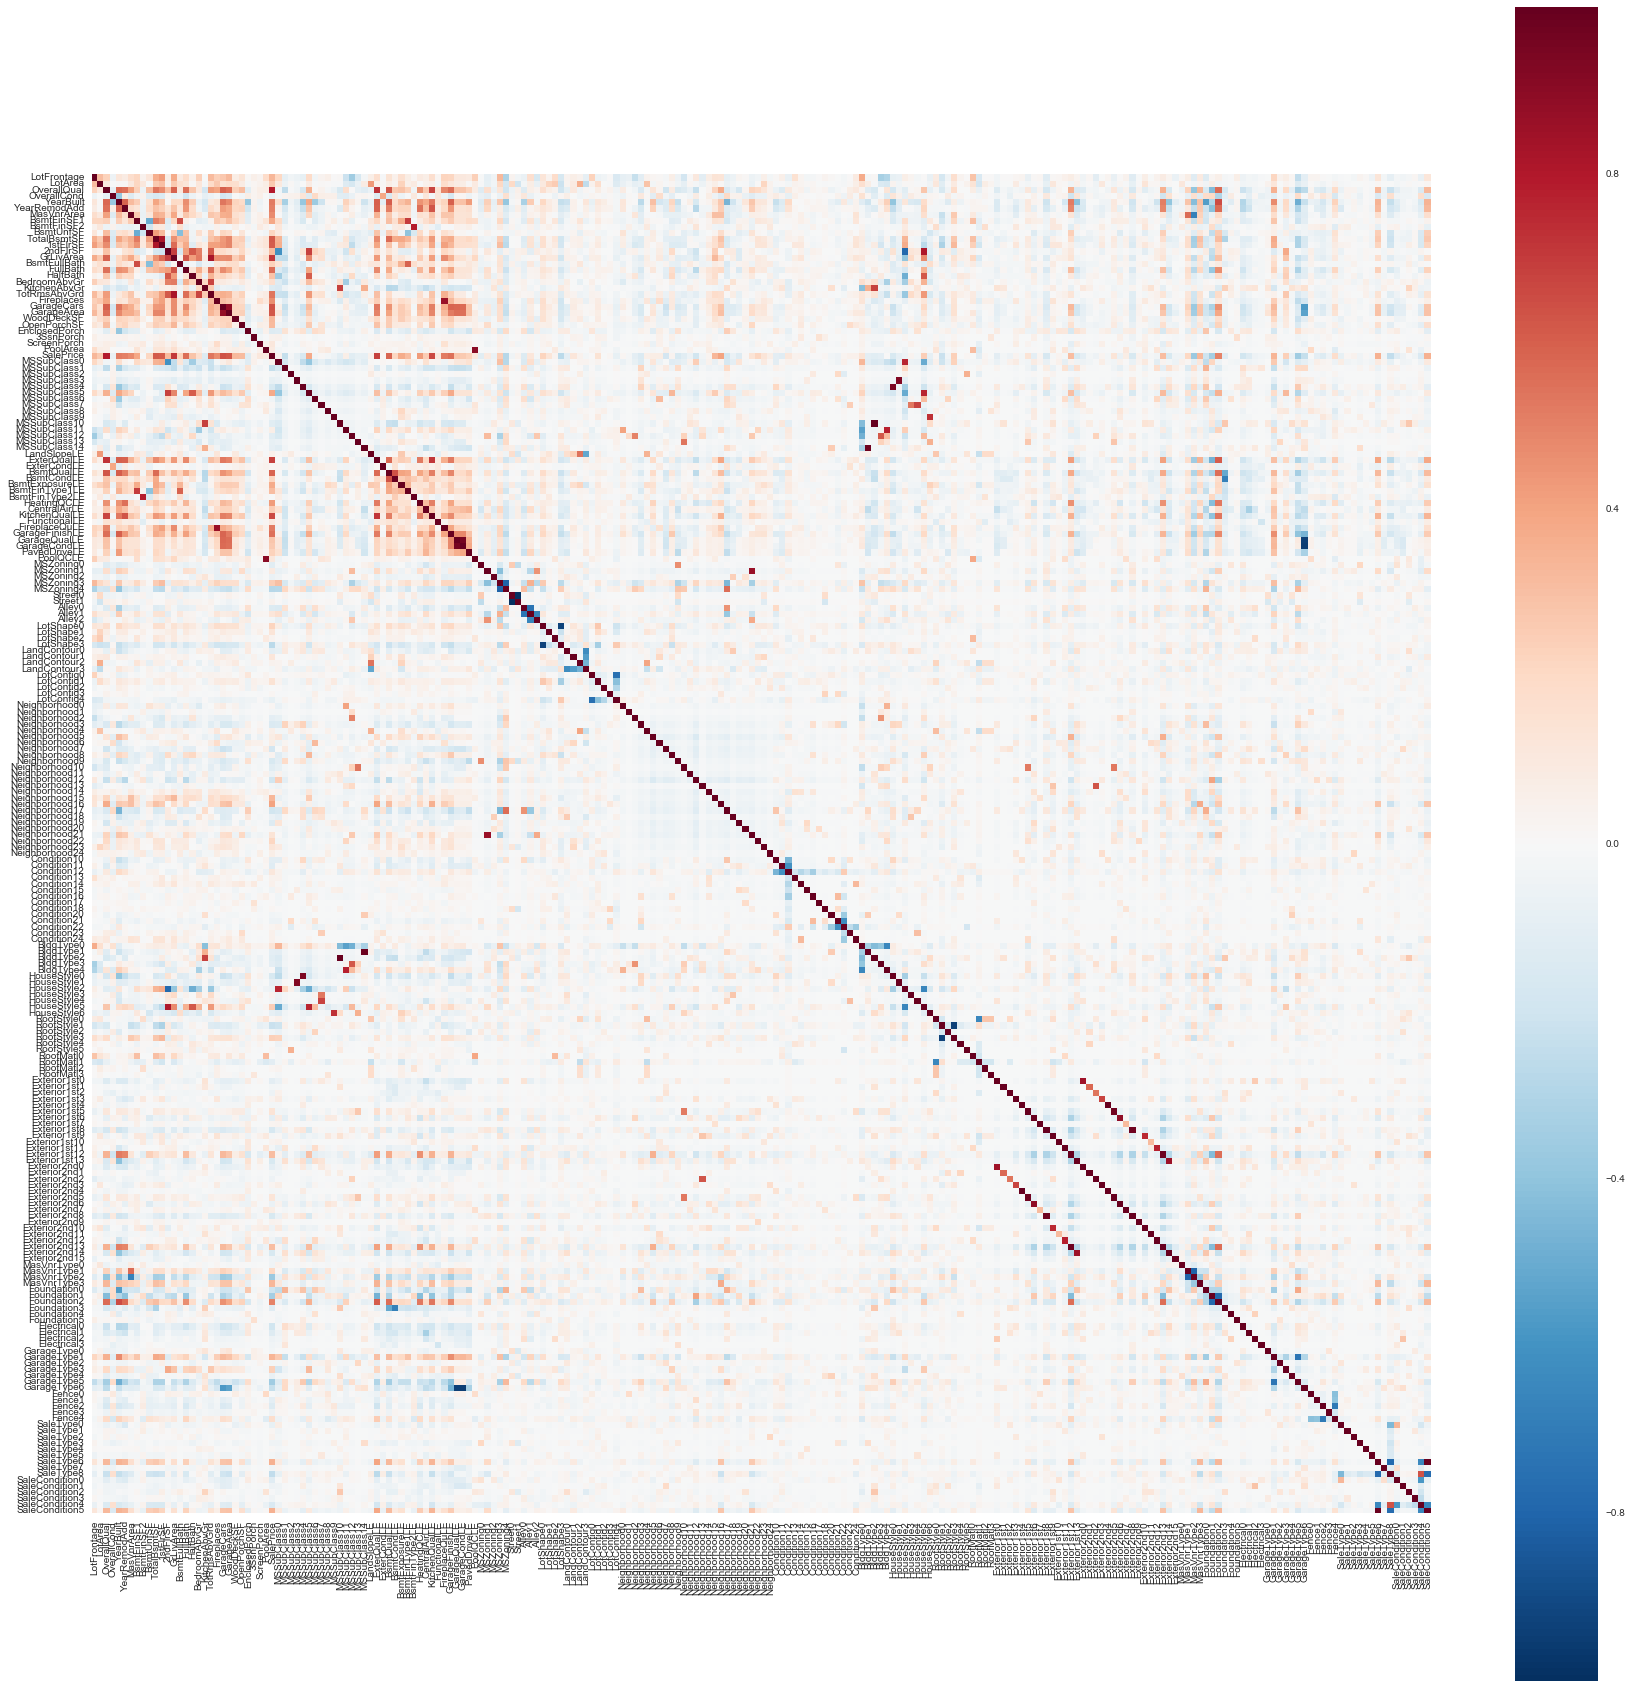

In [214]:
corr = train.select_dtypes(include= ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, vmax=1, square=True)

In [212]:
cor_dict = corr['SalePrice'].to_dict()
del cor_dict['SalePrice']
print 'List the numerical features decendingly by their correlations with Sale Price:\n'
for ele in sorted(cor_dict.items(), key=lambda x: -abs(x[1])):
    print "{0}: \t{1}".format(*ele)

List the numerical features decendingly by their correlations with Sale Price:

OverallQual: 	0.790981600584
GrLivArea: 	0.708624477613
ExterQualLE: 	0.682639241656
KitchenQualLE: 	0.659599720729
GarageCars: 	0.640409197258
GarageArea: 	0.623431438918
TotalBsmtSF: 	0.613580551559
1stFlrSF: 	0.605852184692
BsmtQualLE: 	0.585207199173
FullBath: 	0.560663762748
GarageFinishLE: 	0.549246756333
TotRmsAbvGrd: 	0.533723155582
YearBuilt: 	0.522897332879
FireplaceQuLE: 	0.52043760595
YearRemodAdd: 	0.507100967111
Foundation2: 	0.497733752587
MasVnrArea: 	0.475241316774
Fireplaces: 	0.466928836752
HeatingQCLE: 	0.427648707399
Neighborhood16: 	0.402148598175
BsmtFinSF1: 	0.386419806242
MSSubClass5: 	0.377197068428
BsmtExposureLE: 	0.374696221001
MasVnrType2: 	-0.374467673455
SaleType6: 	0.357509405083
GarageType5: 	-0.354140788413
SaleCondition5: 	0.352059854671
Foundation1: 	-0.343262999445
GarageType1: 	0.33596064721
LotFrontage: 	0.334900851541
MasVnrType3: 	0.330475646543
Neighborhood15: 	0.3

### Top 15 features that correlate with sale price
|  Feature           |         Correlation |
|--------------------|---------------------|
|1. OverallQual: 	 |   0.790981600584    |
|2. GrLivArea: 	     |0.708624477613 |
|3. ExterQualLE: 	|0.682639241656|
|4. KitchenQualLE: 	|0.659599720729|
|5. GarageCars: 	|0.640409197258|
|6. GarageArea: 	|0.623431438918|
|7. TotalBsmtSF: 	|0.613580551559|
|8. 1stFlrSF: 	|0.605852184692|
|9. BsmtQualLE: 	|0.585207199173|
|10. FullBath: 	|0.560663762748|
|11. GarageFinishLE: |	0.549246756333|
|12. TotRmsAbvGrd: |	0.533723155582|
|13. YearBuilt: 	|0.522897332879|
|14. FireplaceQuLE: |	0.52043760595|
|15. YearRemodAdd: 	|0.507100967111|